# Notebook to process Kaggle's Titanic dataset

This notebook uses the dataset from Kaggle's Titanic Comptetition to train a logistic regression and provides results with the test dataset
https://www.kaggle.com/c/titanic

## Configuration
User configuration parameters

In [189]:
train_size = 80 # % of the training set used for training
N_MonteCarlo = 50 # number of runs for the monte-carlo analysis

## Data pre-processing and exploratory data analysis
Gather the train dataset, convert feature to numerical values and plot the values in stacked histograms to get a feeling of the importance of the features.

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image, display


def assignNumericalType (aSeries):
    '''Assigns a numerical type to string values'''
    val = aSeries.unique()
    myDict = {val[x]:x for x in range(len(val))}
    myDict[np.nan] = np.nan # Ensure nan stays nan
    aOut = [myDict[x] for x in aSeries]
    return aOut
    
# Load into CSV
myInDf = pd.read_csv('train.csv', index_col=0)

# Convert strings to numerical type
for myCol in myInDf.columns:
    if type(myInDf[myCol].dropna().iloc[0])==str:
        myInDf[myCol] = assignNumericalType(myInDf[myCol])

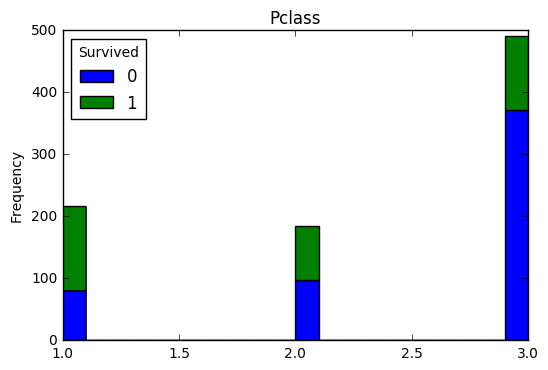

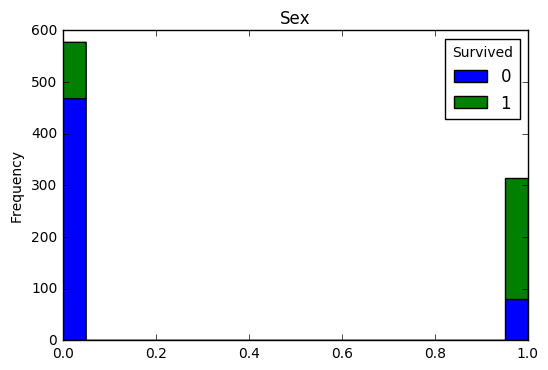

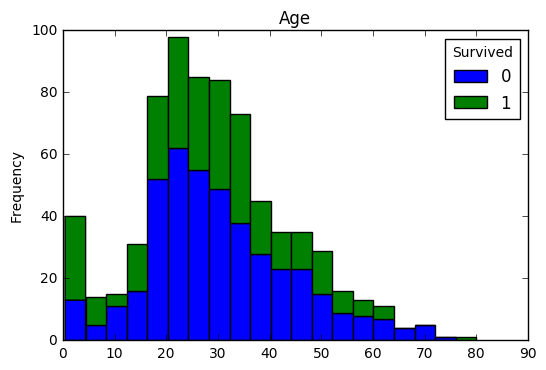

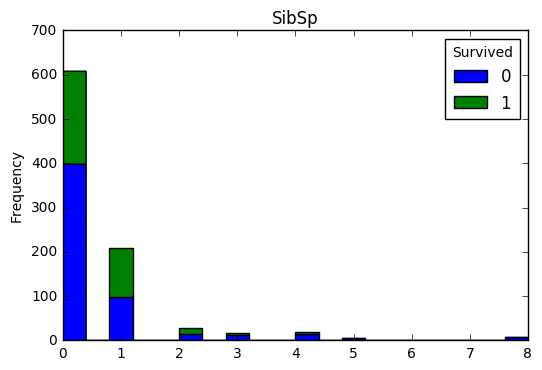

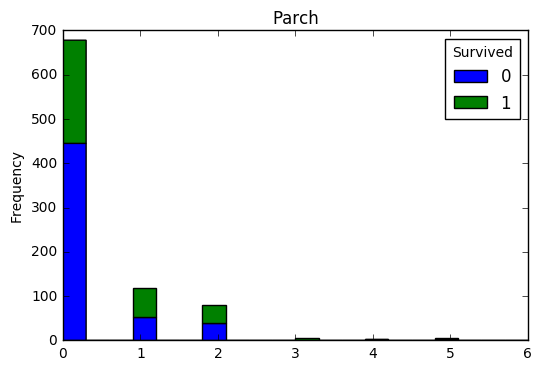

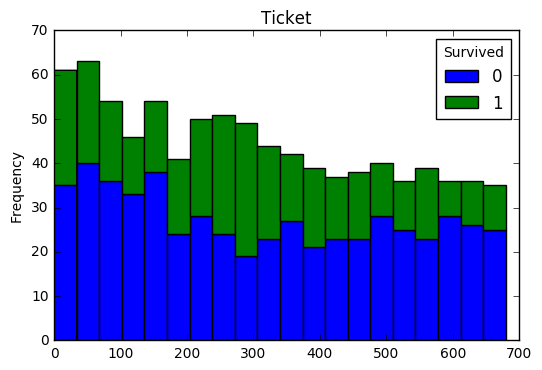

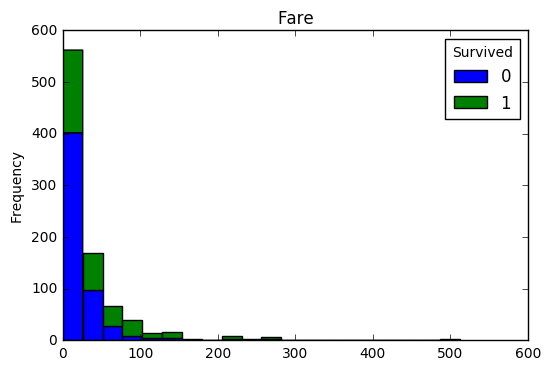

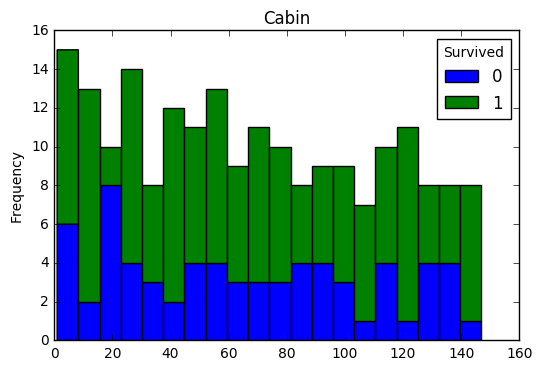

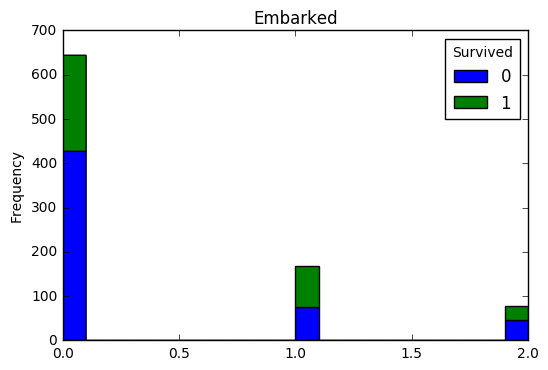

In [111]:
# Exploratory data analysis
for myFeature in myInDf.columns:
    if myFeature != 'Survived' and (len(myInDf[myFeature]) > len(myInDf[myFeature].unique())):
        myInDf.pivot(columns='Survived', values=myFeature).plot(kind='hist', stacked=True, bins=20)
        plt.title(myFeature)
        plt.show()

## Conclusions of the exploratory data analysis

* Passenger on the age 20-40 are more likely to die.
* Babies and infants are more likely to survive.
* Most passenger where in the range 20-40 with children (i.e. families).
* Older people is more likely to survive
* Lower fares are more likely to die
* People with more than 3 siblings is likely to die
* Travelling with no siblings meant a higher change of survival
* People not related to children are more likely to die
* There is a clear dependence on passenger class
* Males are more likely to die
* There is a certain dependence on the cabin, port and ticket

# Classification using decision trees

In [342]:
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score
    
def splitDataset (aDf, aFrac):
    '''Splits a Df in a training and a validation dataset randomly'''
    aTrainDf = aDf.sample(frac=aFrac/100.)
    myValInd = [ind for ind in aDf.index if ind not in aTrainDf.index]
    aValDf = aDf.loc[myValInd]
    # Create X and Y datasets
    aXtrain = aTrainDf[[x for x in myTrainDf.columns if x!='Survived']]
    aYtrain = aTrainDf['Survived']
    aXval = aValDf[[x for x in aTrainDf.columns if x!='Survived']]
    aYval = aValDf['Survived']
    return aXtrain, aYtrain, aXval, aYval

def assessPerformance (aX, aY):
    '''Prints the performance of a certain machine learning algorithm'''
    myYpred = myClf.predict(aX)
    aPrecision = precision_score(aY, myYpred)
    aRecall = recall_score(aY, myYpred)
    aF1score = f1_score(aY, myYpred)
    return aPrecision, aRecall, aF1score

def trainPredictAndAnalyze (aDf, aDepth=None, draw=False):
    # Build a decision tree classifier
    myXtrain, myYtrain, myXval, myYval = splitDataset (aDf, train_size)
    myClf = tree.DecisionTreeClassifier(max_depth=aDepth)
    myClf = myClf.fit(myXtrain, myYtrain)
    aTrainPrecision, aTrainRecall, aTrainF1 = assessPerformance(myXtrain, myYtrain)
    aValPrecision, aValRecall, aValF1 = assessPerformance(myXval, myYval)
    if draw:
        # Draw the decision tree
        myDotData = tree.export_graphviz(myClf, feature_names=myXtrain.columns, out_file='tree.dot' )
        (myGraph,) = pydot.graph_from_dot_file('tree.dot')
        myPlt = Image(myGraph.create_png())
        myGraph.write_png('tree.png')
        display(myPlt)
    return aTrainPrecision, aTrainRecall, aTrainF1, aValPrecision, aValRecall, aValF1
   
def runMonteCarlo (aDf, aDepth=None):
    myPerfDf = pd.DataFrame(columns=['Train Precision', 'Train Recall', 'Train F1', 'Val Precision', 'Val Recall', 'Val F1'])
    for i in range(N_MonteCarlo):
        myPerfDf.loc[i] = trainPredictAndAnalyze(aDf, aDepth)
    return myPerfDf

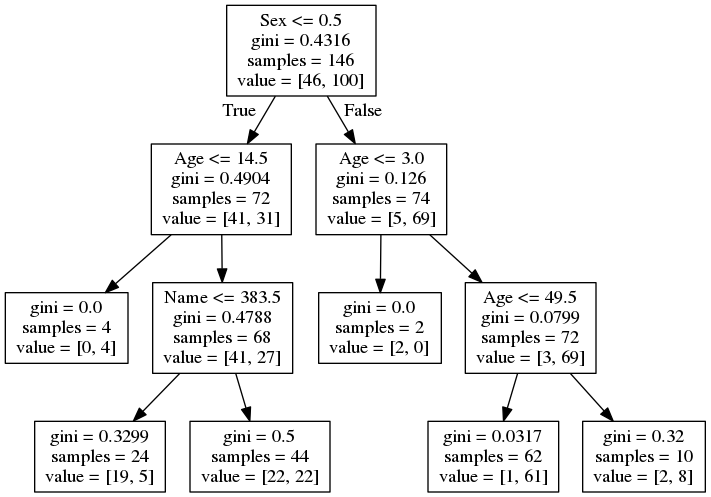

In [345]:
# Calling and drawing a precision tree with max_depth
foo = trainPredictAndAnalyze(myInDf.dropna(), aDepth=3, draw=True)

Try out different cleaning methods for the data, since the data has many missing values

In [305]:
# Removing all the nan
myStats = runMonteCarlo(myInDf.dropna()).describe()
myStats

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.960096,0.917795,0.938411,0.948164,0.922755,0.934379
std,0.011105,0.011633,0.008564,0.042853,0.044529,0.032948
min,0.945055,0.895833,0.919786,0.800000,0.807692,0.851064
25%,0.950499,0.908163,0.933503,0.916667,0.896053,0.913043
50%,0.957671,0.918367,0.937500,0.957428,0.920000,0.938776
75%,0.968085,0.924318,0.943590,0.991379,0.960000,0.956028
max,1.000000,0.948454,0.958763,1.000000,1.000000,1.000000


In [262]:
# Changing all the nan values to a value that it is uncorrelated from the other values
runMonteCarlo(myInDf.replace(np.nan, -1)).describe()


,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.483804,0.718503,0.578166,0.481386,0.723458,0.576787
std,0.009966,0.012639,0.008895,0.040620,0.051348,0.036444
min,0.467153,0.691756,0.562592,0.392157,0.623377,0.500000
25%,0.475246,0.712263,0.571003,0.461072,0.685764,0.552665
50%,0.483191,0.719424,0.577582,0.483766,0.718750,0.580317
75%,0.488806,0.728179,0.584115,0.514868,0.743503,0.606267
max,0.506143,0.747170,0.596237,0.551020,0.841270,0.639535


In [263]:
# Removing all the features with nan values on it
from sklearn.preprocessing import Imputer
myImp = Imputer(missing_values='NaN', strategy='mean', axis=1)
myImp.fit(myInDf)
myNewDf = pd.DataFrame(myImp.transform(myInDf), columns=myInDf.columns)
runMonteCarlo(myNewDf).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.618303,0.719564,0.665024,0.609352,0.718563,0.658217
std,0.012532,0.012680,0.010445,0.051677,0.054662,0.044279
min,0.591195,0.690391,0.642735,0.478873,0.548387,0.511278
25%,0.609078,0.712379,0.658631,0.575000,0.691459,0.631605
50%,0.619135,0.718521,0.664965,0.606380,0.722298,0.659977
75%,0.626959,0.727024,0.671981,0.646897,0.747984,0.686500
max,0.646341,0.757143,0.697368,0.716049,0.852459,0.743590


# Conclusion
A decision tree where all the rows that contained nan has been filtered and using as many features as possible is the best classifier with F1score ~ 90%

## Preventing overtitting

Here a number of draws will be done on the validation set to come up with a level of depth that minimizes the validation error

In [348]:
# Create a MultiIndex dataframe to store the stats of all the different runs
myMaxDepthArray = np.array(range(len(myTrainDf.columns)))+1
myIndex = pd.MultiIndex.from_product([myMaxDepthArray, myStats.index])
myDf = pd.DataFrame(index=myIndex, columns=myStats.columns)
for myDepth in myMaxDepthArray:
    myDf.loc[myDepth,:].iloc[:] = runMonteCarlo(myInDf.dropna(), aDepth=myDepth).describe().iloc[:]
myDf

Train Precision Train Recall    Train F1 Val Precision Val Recall  \
1  count              50           50          50            50         50   
   mean         0.956761     0.918736     0.93731      0.960796   0.916886   
   std         0.0102139    0.0108965  0.00781827      0.041607  0.0456645   
   min          0.945055     0.896907     0.92228      0.857143   0.772727   
   25%          0.947505     0.910223    0.932642      0.931723   0.885684   
   50%          0.956283     0.918367    0.937171      0.962251       0.92   
   75%          0.965099     0.927647    0.943294             1   0.956028   
   max          0.979381     0.950495    0.952381             1          1   
2  count              50           50          50            50         50   
   mean         0.957276     0.916933    0.936606      0.958908   0.926259   
   std        0.00940001    0.0119089  0.00747547     0.0379771  0.0492963   
   min          0.945055     0.894737     0.92228         0.875   0.772727   
   25%          0.947917     0.907216    0.931397      0.923789   0.888889   
   50%          0.956755     0.917526    0.935827      0.960769   0.923077   
   75%          0.967302     0.927083    0.941043             1   0.961538   
   max          0.978723     0.950495        0.96             1          1   
3  count              50           50          50            50         50   
   mean         0.959467     0.919397    0.938951      0.951253   0.916851   
   std        0.00930387    0.0120229   0.0081248     0.0357867  0.0481233   
   min          0.946237     0.897959    0.926316      0.862069   0.818182   
   25%          0.956044     0.909318    0.932815      0.926587   0.881154   
   50%          0.957895     0.917096     0.93846      0.956522   0.924501   
   75%          0.966941     0.928387    0.945858      0.962963    0.95788   
   max          0.988764     0.940594    0.959184             1          1   
4  count              50           50          50            50         50   
   mean         0.957837     0.919603    0.938275      0.955361   0.915121   
   std         0.0104083    0.0120687  0.00864459     0.0420597  0.0465496   
   min          0.943182     0.892473    0.917127      0.842105        0.8   
   25%          0.947917     0.911846    0.933333      0.923077   0.889881   
   50%          0.957895     0.919192    0.937822      0.956522   0.916667   
...                  ...          ...         ...           ...        ...   
8  std        0.00960699    0.0115194  0.00762691     0.0365591   0.046292   
   min          0.944444     0.896907    0.920635      0.857143   0.807692   
   25%          0.950746     0.907216    0.932114          0.92   0.913043   
   50%          0.958114     0.911765    0.935827      0.955534   0.952381   
   75%          0.967742         0.92    0.941484      0.990741   0.961538   
   max          0.988889     0.948454    0.952381             1          1   
9  count              50           50          50            50         50   
   mean         0.957724     0.916864    0.936799      0.956594   0.925801   
   std         0.0088166    0.0124307  0.00842605     0.0352953  0.0503566   
   min           0.94382     0.893617    0.918033         0.875   0.791667   
   25%          0.948051     0.908395    0.931217      0.923077   0.893781   
   50%          0.957671     0.917947    0.935404      0.957428   0.921538   
   75%          0.967391      0.92612    0.942256             1   0.959583   
   max          0.978723     0.949495    0.954774             1          1   
10 count              50           50          50            50         50   
   mean         0.957781     0.917936    0.937387      0.957481   0.920485   
   std        0.00984864    0.0123093  0.00887907     0.0383573  0.0481501   
   min           0.94382     0.893617    0.918033      0.851852   0.791667   
   25%          0.947917     0.908163    0.931397      0.923789       0.88   
   50%          0.957218     0.